# Context

Survival - Выживший:	0 = Нет, 1 = Да
Pclass	- Класс каюты:	1 = 1-ый, 2 = 2-ой, 3 = 3-ий
Sex	- Пол
Age	- Возраст в годах
Sibsp - Сестры или братья / родственники не на борту Титаника
Parch - Родители / дети не на борту Титаника
Ticket	- Номер билета
Fare - Стоимость билета
Cabin	- Номер каюты
Embarked - Порт посадки:	C = Cherbourg, Q = Queenstown, S = Southampton

Целью данного исследования является выявление признаков, влияющих на выживаемость пассажиров.

# Data quality assessment

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
titanic = pd.read_csv('train.csv', sep=',')
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
5,5,0,2,"Sassano, Jonathan",male,35.00,0,0,13363,6.71,NaN,S
6,6,0,3,"Conway, Jose",male,7.00,0,0,A/5,9.77,NaN,S
7,7,1,3,"Werner, Linda",female,6.00,1,2,434426,31.50,NaN,S
8,8,0,1,"Wardlaw, Michael",male,27.00,2,1,474849,73.02,A7253,S
9,9,0,2,"Greigo, Rudy",male,66.00,0,0,6981,9.14,D2969,C


При рассмотрении данных, можно определить явные переменные, которые не оказывают никакого влияния на полученные результаты. Таким образом сразу можно исключить переменные 'Name' и 'fare'. Так как 'fare' - стоимость билета влияет только на класс каюты пассажира, однако не оказывает влияния на итоговый результат. Номер билета - 'Ticket', место посадки - 'Embarked' также как и номер каюты - 'Cabin', тоже не влияют на выживаемость пассажира.

In [98]:
titanic_data = titanic.drop(columns=['Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1)
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Sex          100000 non-null  object 
 4   Age          96708 non-null   float64
 5   SibSp        100000 non-null  int64  
 6   Parch        100000 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 5.3+ MB


# Data exploration

Из полученной информации видно, что значения Age, имеет некоторое количество пропусков, которые следует либо исключить, либо заполнить средним значением. Я предпочту второй вариант. Для этого сначала заполним пропуски 0, а затем определим для каждого из полов количество выживших и погибших.


In [99]:
titanic_data = titanic_data.fillna(0)

male_survived = titanic_data.loc[(titanic_data['Age']==0.00) & (titanic_data['Sex']=='male')].groupby('Survived').agg({'Survived': 'count'})
print(male_survived)
female_survived = titanic_data.loc[(titanic_data['Age']==0.00) & (titanic_data['Sex']=='female')].groupby('Survived').agg({'Survived': 'count'})
print(female_survived)

          Survived
Survived          
0             1517
1              390
          Survived
Survived          
0              419
1              966


Можно заметить, что среди мужчин с пропущенным значением возраста преобладает количество погибших, у женщин же - обратная ситуация. Таким образом, пропущенные значения возраста мужчин можно заполнить средним значением возраста погибших мужчин, а у женщин - средним значением возраста выживших женщин.

In [100]:
mean_fem_age = round(titanic_data.loc[(titanic_data['Survived']==1) & (titanic_data['Sex']=='female') & (titanic_data['Age'] != 0.00)].Age.mean(), 2)
print(mean_fem_age)

mean_man_age = round(titanic_data.loc[(titanic_data['Survived']==0) & (titanic_data['Sex']=='male') & (titanic_data['Age'] != 0.00)].Age.mean(), 2)
print(mean_man_age)

41.27
36.62


Теперь заполним пропущенные значения мужчин и женщин полученными значениями.

In [101]:
titanic_data.loc[(titanic_data['Sex'] == 'male') & (titanic_data['Age'] == 0.00), 'Age'] = 36.62
titanic_data.loc[(titanic_data['Sex'] == 'female') & (titanic_data['Age'] == 0.00), 'Age'] = 41.27

 Для того, чтобы определить, являются ли данные переменные значимыми, построим тепловую карту, отражающую корреляцию переменных.
Так как данный тип графиков применим только для числовых переменных, следует заменить категориальные значения на числовые. Таким образом, в графе Sex, изменим значение male - 0, female - 1.

<AxesSubplot:>

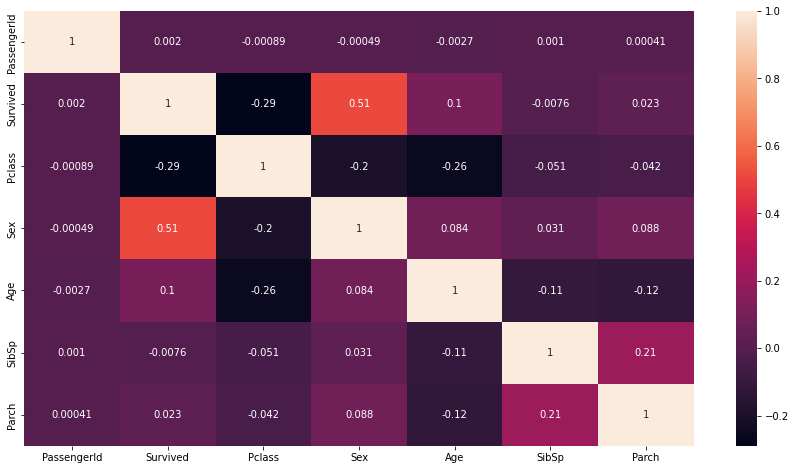

In [102]:
titanic_data['Sex'] = titanic_data['Sex'].replace({'male': 0, 'female': 1})
plt.figure(figsize = (15,8))
sns.heatmap(titanic_data.corr(), annot=True)

Исходя из полученных данных, можно сделать выводы,что наиболее коррелирующими признаками в данном датасете являются Survived и Sex. Поэтому, для того, чтобы детальнее рассмотреть предположение о том, что в первую очередь уровень выживаемости зависел от пола пассажира, построим график.

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

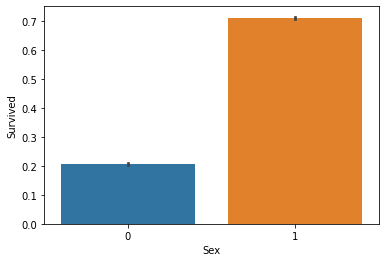

In [109]:
sns.barplot(x='Sex', y='Survived', data=titanic_data)

Таким образом можно сделать вывод, что среди всех пассажиров Титаника, женщин действительно выжило больше, чем мужчин.

<AxesSubplot:xlabel='Age', ylabel='Count'>

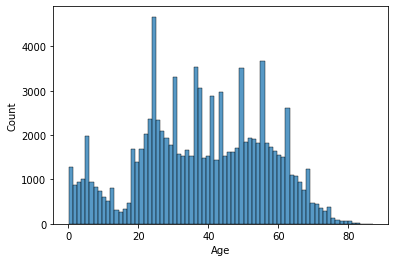

In [105]:
sns.histplot(data=titanic_data, x=titanic_data['Age'])

<AxesSubplot:xlabel='Survived', ylabel='Age'>

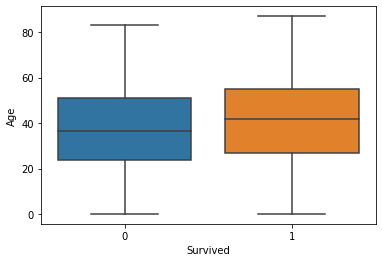

In [94]:
sns.boxplot(x=titanic_data['Survived'], y=titanic_data['Age'])

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

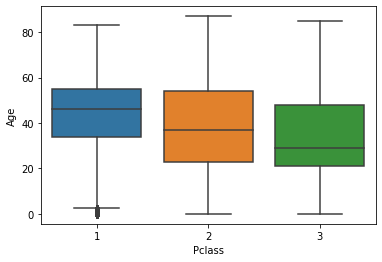

In [38]:
sns.boxplot(x=titanic_data['Pclass'], y=titanic_data['Age'])

# Summary

<AxesSubplot:xlabel='Survived', ylabel='Pclass'>

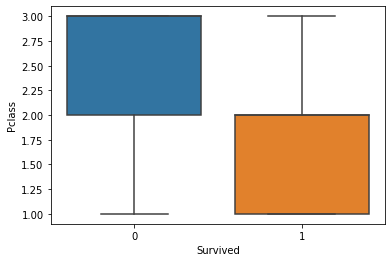

In [39]:
sns.boxplot(x=titanic_data['Survived'], y=titanic_data['Pclass'])

In [42]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,1,1,0,0.00,2,0
1,1,0,3,0,0.00,0,0
2,2,0,3,0,0.33,1,2
3,3,0,3,0,19.00,0,0
4,4,1,3,0,25.00,0,0


<AxesSubplot:xlabel='Parch', ylabel='Count'>

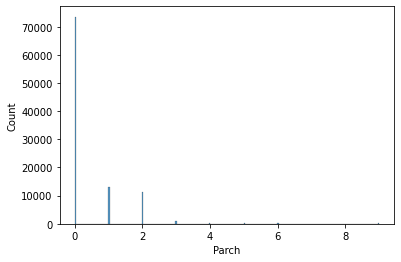

In [43]:
sns.histplot(x='Parch', data=titanic_data)

In [44]:
print(titanic_data)

       PassengerId  Survived  Pclass  Sex    Age  SibSp  Parch
0                0         1       1    0   0.00      2      0
1                1         0       3    0   0.00      0      0
2                2         0       3    0   0.33      1      2
3                3         0       3    0  19.00      0      0
4                4         1       3    0  25.00      0      0
...            ...       ...     ...  ...    ...    ...    ...
99995        99995         1       2    1  62.00      0      0
99996        99996         0       2    0  66.00      0      0
99997        99997         0       3    0  37.00      0      0
99998        99998         0       3    0  51.00      0      1
99999        99999         0       3    0  55.00      0      0

[100000 rows x 7 columns]
